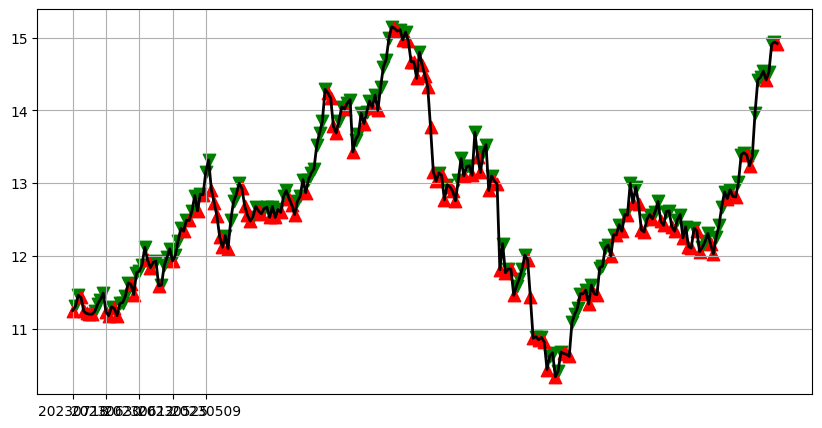

In [2]:
import tushare as ts
#pro = ts.pro_api('3337990cd3204d24e06a0b8569ec8d454aa2c056216b958b5e393c05')
#data = pro.query('stock_basic', exchange='', list_status='L', fields='ts_code')
ts.set_token('3337990cd3204d24e06a0b8569ec8d454aa2c056216b958b5e393c05')#设置token，只需设置一次
api = ts.pro_api()#初始化接口
#指定一下获取股票数据的起始日期和截止日期
#这里就用2020年1月1日至3月18日的数据
start_date = '2020-01-01'
end_date = '2020-03-18'
#创建数据表，这里选择下载的股票代码为601318
#并把我们把设定的开始日期和截止日期作为参数传入
#pro = ts.pro_api()
data = api.daily(ts_code='000001.SZ', start_date='20220701', end_date='20230718')
#data = api.get_k_data('601318',start = start_date,end = end_date)
data = data.set_index('trade_date')
#下面来检查一下数据表的前5行
data.head()
#给新的字段命名为diff，代表difference
#用.diff()方法来计算每日股价变化情况
data['diff'] = data['close'].diff()
#检查一下前5行
data.head()

#此处会用到numpy，故导入
import numpy as np
#创建交易信号字段，命名为Signal
#如果diff值大于0，则Signal为1，否则为0
data['Signal'] = np.where(data['diff'] > 0, 1, 0)
#检查是否成功
data.head()

#导入画图工具matplotlib
import matplotlib.pyplot as plt
#设置画布的尺寸为10*5
plt.figure(figsize = (10,5))
#使用折线图绘制出每天的收盘价
plt.plot(data['close'],linewidth=2, color='k')
#如果当天股价上涨，标出卖出信号，用倒三角表示
plt.scatter(data['close'].loc[data.Signal==1].index,
        data['close'][data.Signal==1],
        marker = 'v', s=80, c='g')
#如果当天股价下跌给出买入信号，用正三角表示
plt.scatter(data['close'].loc[data.Signal==0].index,
        data['close'][data.Signal==0],
        marker = '^', s=80, c='r')
plt.xticks([0,12,24,36,48])
plt.grid()
#将图像进行展示
plt.show()

In [4]:
!pip install seaborn

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
You should consider upgrading via the '/Users/stella/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [8]:
#下面我们来创建交易信号
#为了不影响原始数据，这里创建一个新的数据表
#只保留原始数据中的日期index
zgpa = data
zgpa_signal = pd.DataFrame(index = zgpa.index)
#为了更能体现股票的真实价值
#使用Adj Close调整价格作为股票价格
zgpa_signal['price'] = zgpa['close']
#增加一个字段，来存储股价的变化
zgpa_signal['diff'] = zgpa_signal['price'].diff()
#增加diff字段后，第一行会出现空值，我们使用0来进行填补
zgpa_signal = zgpa_signal.fillna(0.0)
#如果股价上涨或不变，则标记为0
#如果股价下跌，则标记为1
zgpa_signal['signal'] = np.where(zgpa_signal['diff'] >= 0, 0,1)
#接下来，根据交易信号的变化进行下单
#一般情况下，在A股市场，买入或卖出至少为100股，即1手
zgpa_signal['order'] = zgpa_signal['signal'].diff()*100
#检查一下下单的情况
zgpa_signal.head()

,price,diff,signal,order
trade_date,,,,
20230718,11.25,0.00,0,NaN
20230717,11.31,0.06,0,0.0
20230714,11.46,0.15,0,0.0
20230713,11.43,-0.03,1,100.0
20230712,11.24,-0.19,1,0.0


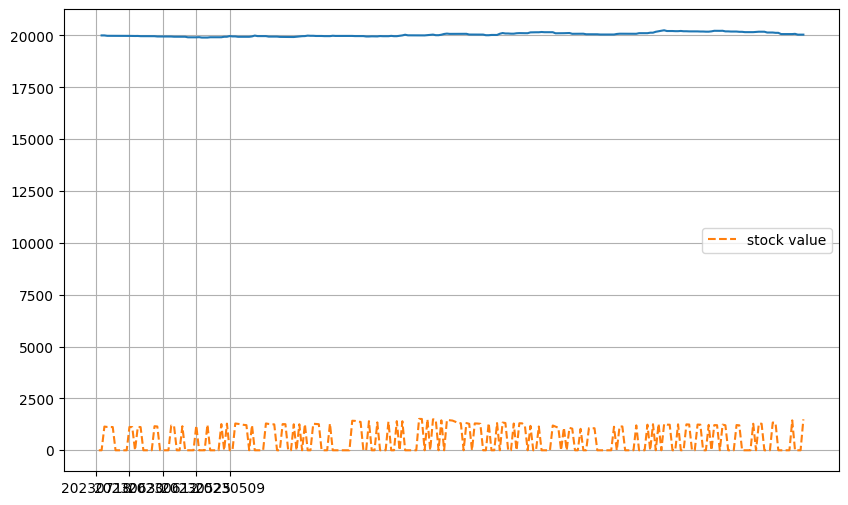

In [9]:
#考虑到股价较高，我们初始给小瓦2万块钱让她去交易
initial_cash = 20000.00
#增加一个字段，代表小瓦交易的股票的市值
zgpa_signal['stock'] = zgpa_signal['order']*zgpa_signal['price']
#两次买卖的订单变化之差就是某一时刻小瓦仓位的变化情况
#持仓股票的数量变化乘以现价，就是代表小瓦交易产生的现金流
#用初始资金减去现金流变化的累加，就是小瓦剩余的现金
zgpa_signal['cash'] = initial_cash -\
(zgpa_signal['order'].diff()*zgpa_signal['price']).cumsum()
#而最股票的市值加上剩余的现金，就是小瓦的总资产
zgpa_signal['total'] = zgpa_signal['stock'] + zgpa_signal['cash']
#为了让小瓦直观看到自己的总资产变化
#我们用图形来进行展示
#设置图形的尺寸是10*6
plt.figure(figsize=(10,6))
#分别绘制总资产和持仓股票市值的变化
plt.plot(zgpa_signal['total'])
plt.plot(zgpa_signal['order'].cumsum()*zgpa_signal['price'],'--',
        label='stock value')
#增加网格，调整一下图注的位置，就可以显示图像了
plt.xticks([0,12,24,36,48])
plt.grid()
plt.legend(loc='center right')
plt.show()

In [ ]:
以下是移动平均策略

In [10]:
#这里使用10日均线
period = 10
#设置一个空列表，用来存储每10天的价格
avg_10 = []
#再设置一个空列表，用来存储每10天价格的均值
avg_value = []
#设置一个循环
for price in zgpa['close']:
    #把每天的价格传入到avg_10列表
    avg_10.append(price)
    #当列表中存储的数值多于10个时
    if len(avg_10) > period:
        #就把前面传入的价格数据删掉，确保列表中只有10天的数据
        del avg_10[0]
    #将10天数据的均值传入到avg_value列表中
    avg_value.append(np.mean(avg_10))
#把计算好的10日均价写到股票价格数据表中
zgpa = zgpa.assign(avg_10 = pd.Series(avg_value, index = zgpa.index))
#检查一下是否添加成功
zgpa.head()

,ts_code,open,high,low,close,pre_close,change,pct_chg,vol,amount,diff,Signal,avg_10
trade_date,,,,,,,,,,,,,
20230718,000001.SZ,11.29,11.32,11.22,11.25,11.31,-0.06,-0.5305,471966.18,531299.773,NaN,0,11.2500
20230717,000001.SZ,11.41,11.41,11.26,11.31,11.46,-0.15,-1.3089,608342.58,687262.894,0.06,1,11.2800
20230714,000001.SZ,11.43,11.55,11.40,11.46,11.43,0.03,0.2625,719146.99,825295.738,0.15,1,11.3400
20230713,000001.SZ,11.32,11.47,11.27,11.43,11.24,0.19,1.6904,1124229.73,1281848.379,-0.03,0,11.3625
20230712,000001.SZ,11.23,11.36,11.22,11.24,11.21,0.03,0.2676,736083.67,830230.821,-0.19,0,11.3380


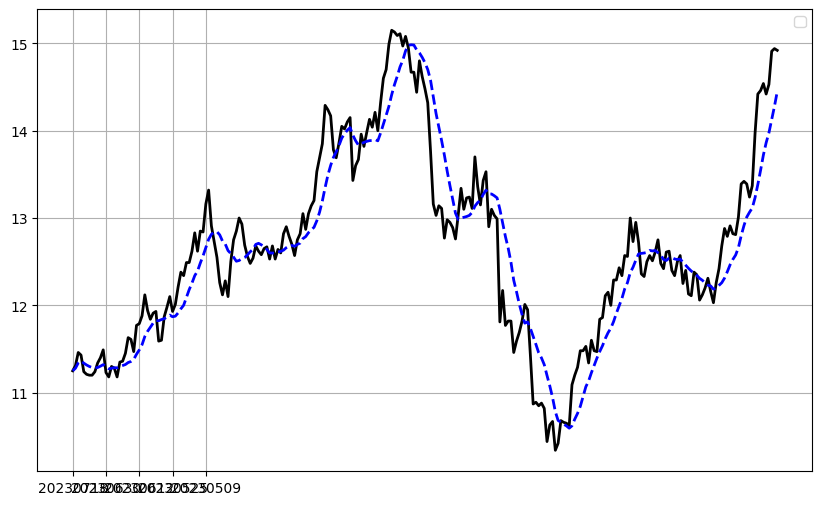

In [11]:
#设置图像尺寸为10*6
plt.figure(figsize=(10,6))
#绘制股价的变化
plt.plot(zgpa['close'],lw=2, c='k')
#绘制10日均线
plt.plot(zgpa['avg_10'], '--',lw=2, c='b')
#添加图注和网格
plt.legend()
plt.grid()
plt.xticks([0,12,24,36,48])
#将图像进行显示
plt.show()

In [12]:
#新建一个数据表，命名为strategy（策略）
#序号保持和原始数据一致
strategy = pd.DataFrame(index = zgpa.index)
#添加一个signal字段，用来存储交易信号
strategy['signal'] = 0
#将5日均价保存到avg_5这个字段
strategy['avg_5'] = zgpa['close'].rolling(5).mean()
#同样，将10日均价保存到avg_10
strategy['avg_10'] = zgpa['close'].rolling(10).mean()
#当5日均价大于10日均价时，标记为1
#反之标记为0
strategy['signal'] = np.where(strategy['avg_5']>strategy['avg_10'], 1,0)
#根据交易信号的变化下单，当交易信号从0变成1时买入
#交易信号从1变成0时卖出
#交易信号不变时不下单
strategy['order'] = strategy['signal'].diff()
#查看数据表后10行
strategy.tail(10)

,signal,avg_5,avg_10,order
trade_date,,,,
20220714,1,13.362,13.115,0.0
20220713,1,13.478,13.233,0.0
20220712,1,13.678,13.384,0.0
20220711,1,13.892,13.548,0.0
20220708,1,14.152,13.721,0.0
20220707,1,14.362,13.862,0.0
20220706,1,14.474,13.976,0.0
20220705,1,14.572,14.125,0.0
20220704,1,14.668,14.280,0.0


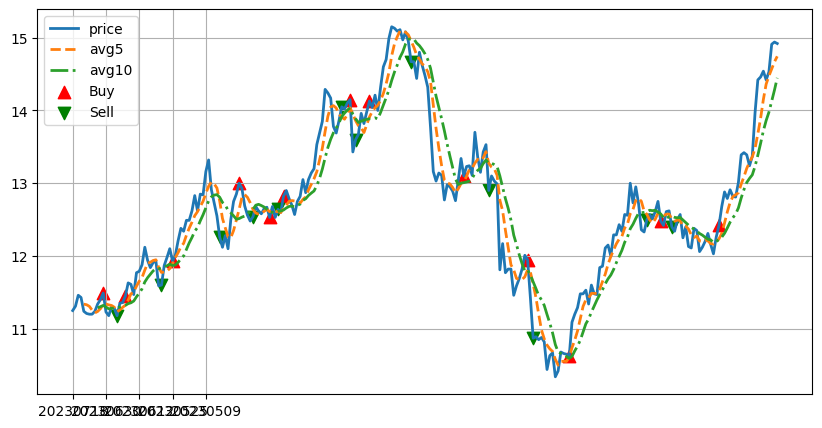

In [13]:
#创建尺寸为10*5的画布
plt.figure(figsize=(10,5))
#使用实线绘制股价
plt.plot(zgpa['close'],lw=2,label='price')
#使用虚线绘制5日均线
plt.plot(strategy['avg_5'],lw=2,ls='--',label='avg5')
#使用-.风格绘制10日均线
plt.plot(strategy['avg_10'],lw=2,ls='-.',label='avg10')
#将买入信号用正三角进行标示
plt.scatter(strategy.loc[strategy.order==1].index,
           zgpa['close'][strategy.order==1],
           marker = '^', s=80,color='r',label='Buy')
#将卖出信号用倒三角进行标示
plt.scatter(strategy.loc[strategy.order==-1].index,
           zgpa['close'][strategy.order==-1],
           marker = 'v', s=80,color='g',label='Sell')
#添加图注
plt.legend()
plt.xticks([0,12,24,36,48])
#添加网格以便于观察
plt.grid()
#显示图像
plt.show()

In [14]:
#这次我们还是给小瓦2万块钱的启动资金
initial_cash = 20000
#新建一个数据表positions，序号保持和strategy数据表一致
#用0将空值进行替换
positions = pd.DataFrame(index = strategy.index).fillna(0)
#因为A股买卖都是最低100股
#因此设置stock字段为交易信号的100倍
positions['stock'] = strategy['signal'] * 100
#创建投资组合数据表，用持仓的股票数量乘股价得出持仓的股票市值
portfolio = pd.DataFrame(index = strategy.index)
portfolio['stock value'] = positions.multiply(zgpa['close'], axis=0)
#同样仓位的变化就是下单的数量
order = positions.diff()
#用初始资金减去下单金额的总和就是剩余的资金
portfolio['cash'] = initial_cash - order.multiply(zgpa['close'],
                                                 axis=0).cumsum()
#剩余的资金+持仓股票市值即为总资产
portfolio['total'] = portfolio['cash'] + portfolio['stock value']
#检查一下后10行
portfolio.tail(10)

,stock value,cash,total
trade_date,,,
20220714,1337.0,18914.0,20251.0
20220713,1397.0,18914.0,20311.0
20220712,1442.0,18914.0,20356.0
20220711,1446.0,18914.0,20360.0
20220708,1454.0,18914.0,20368.0
20220707,1442.0,18914.0,20356.0
20220706,1453.0,18914.0,20367.0
20220705,1491.0,18914.0,20405.0
20220704,1494.0,18914.0,20408.0


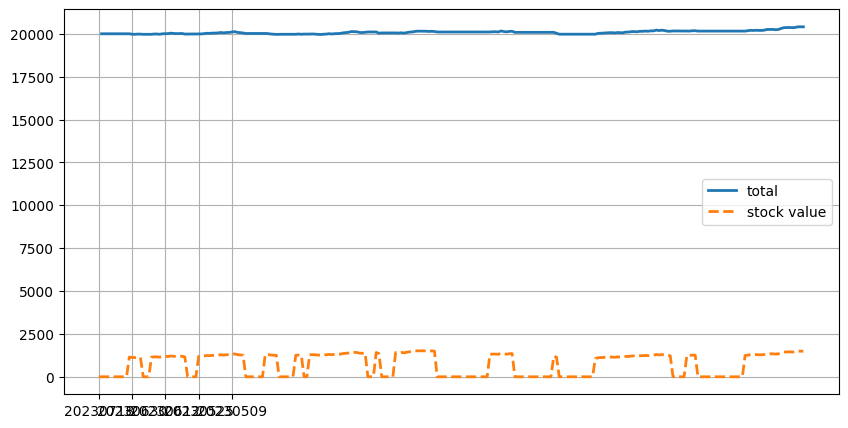

In [15]:
#创建10*5的画布
plt.figure(figsize=(10,5))
#绘制总资产曲线
plt.plot(portfolio['total'], lw=2, label='total')
#绘制持仓股票市值曲线
plt.plot(portfolio['stock value'],lw=2,ls='--', label='stock value')
#添加图注
plt.legend()
#添加网格
plt.grid()
plt.xticks([0,12,24,36,48])
#展示图像
plt.show()

In [ ]:
以下是海龟策略

In [16]:
#创建一个名为turtle的数据表，使用原始数据表的日期序号
turtle = pd.DataFrame(index = zgpa.index)
#设置唐奇安通道的上沿为前5天股价的最高点
turtle['high'] = zgpa['close'].shift(1).rolling(5).max()
#设置唐奇安通道的下沿为过去5天的最低点
turtle['low'] = zgpa['close'].shift(1).rolling(5).min()
#当股价突破上沿时，发出买入信号
turtle['buy'] = zgpa['close'] > turtle['high']
#当股价突破下沿时，发出卖出信号
turtle['sell'] = zgpa['close'] < turtle['low']
#检查信号创建情况
turtle.tail()

,high,low,buy,sell
trade_date,,,,
20220707,14.54,13.37,False,False
20220706,14.54,13.97,False,False
20220705,14.54,14.42,True,False
20220704,14.91,14.42,True,False
20220701,14.94,14.42,False,False


In [17]:
#初始的订单状态为0
turtle['orders']=0
#初始的仓位为0
position = 0
#设置循环，遍历turtle数据表
for k in range(len(turtle)):
    #当买入信号为True且仓位为0时下单买入1手
    if turtle.buy[k] and position ==0:
        #修改对应的orders值为1
        turtle.orders.values[k] = 1
        #仓位也增加1手
        position = 1
    #而当卖出信号为True且有持仓时买出1手
    elif turtle.sell[k] and position > 0:
        #orders的值修改为-1
        turtle.orders.values[k] = -1
        #仓位相应清零
        position = 0   
#检查是否成功
turtle.tail(15)

/var/folders/p9/7m6r8zk540z4r_cbz4nb8yd00000gn/T/ipykernel_50650/569440845.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if turtle.buy[k] and position ==0:
/var/folders/p9/7m6r8zk540z4r_cbz4nb8yd00000gn/T/ipykernel_50650/569440845.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif turtle.sell[k] and position > 0:


,high,low,buy,sell,orders
trade_date,,,,,
20220721,12.91,12.79,True,False,0
20220720,13.01,12.79,True,False,0
20220719,13.39,12.81,True,False,0
20220718,13.42,12.81,False,False,0
20220715,13.42,12.81,False,False,0
20220714,13.42,13.01,False,False,0
20220713,13.42,13.24,True,False,0
20220712,13.97,13.24,True,False,0
20220711,14.42,13.24,True,False,0


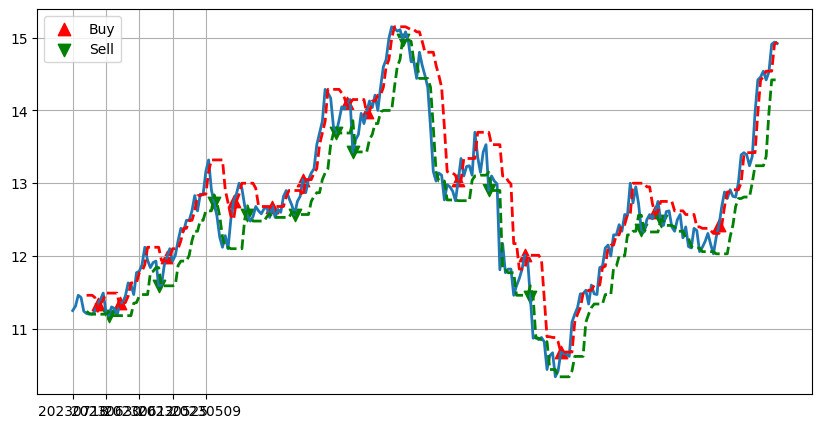

In [18]:
#创建10*5的画布
plt.figure(figsize=(10,5))
#绘制股价的折线图
plt.plot(zgpa['close'],lw=2)
#绘制唐奇安通道上沿
plt.plot(turtle['high'],lw=2, ls='--',c='r')
#绘制唐奇安通道下沿
plt.plot(turtle['low'],lw=2,ls='--',c='g')
#标出买入订单，用正三角标记
plt.scatter(turtle.loc[turtle.orders==1].index,
           zgpa['close'][turtle.orders==1],
           marker='^',s=80,color='r',label='Buy')
#标出卖出订单，用倒三角标记
plt.scatter(turtle.loc[turtle.orders==-1].index,
           zgpa['close'][turtle.orders==-1],
           marker='v',s=80,color='g',label='Sell')
#添加网格、图注并显示
plt.legend()
plt.xticks([0,12,24,36,48])
plt.grid()
plt.show()

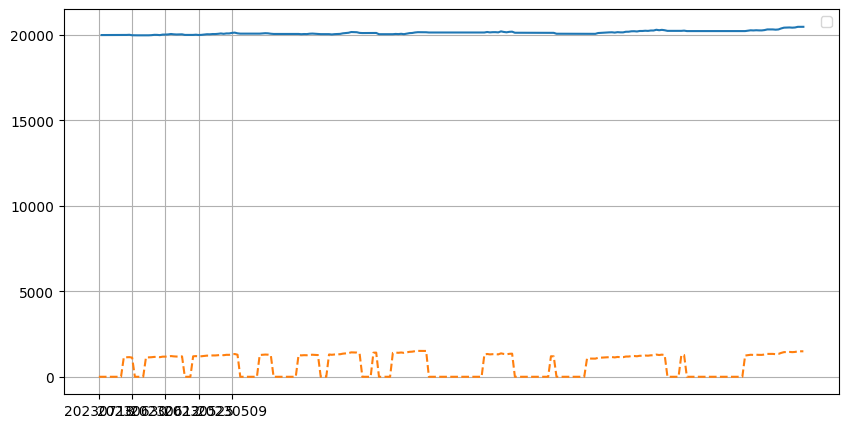

In [19]:
#再次给小瓦2万块初始资金
initial_cash = 20000
#创建新的数据表，序号和turtle数据表一致
positions = pd.DataFrame(index=turtle.index).fillna(0.0)
#每次交易为1手，即100股，仓位即买单和卖单的累积加和
positions['stock'] = 100 * turtle['orders'].cumsum()
#创建投资组合数据表
portfolio = positions.multiply(zgpa['close'], axis=0)
#持仓市值为持仓股票数乘以股价
portfolio['holding_values'] = (positions.multiply(zgpa['close'], axis=0))
#计算出仓位的变化
pos_diff = positions.diff()
#剩余的现金是初始资金减去仓位变化产生的现金流累计加和
portfolio['cash'] = initial_cash - (pos_diff.multiply(zgpa['close'], axis=0)).cumsum()
#总资产即为持仓股票市值加剩余现金
portfolio['total'] = portfolio['cash'] + portfolio['holding_values']
#使用可视化的方式展示
#下面的代码都很熟悉了，就不逐行注释了
plt.figure(figsize=(10,5))
plt.plot(portfolio['total'])
plt.plot(portfolio['holding_values'],'--')
plt.grid()
plt.legend()
plt.xticks([0,12,24,36,48])
plt.show()

In [20]:
#检查最后若干天小瓦的资产情况
portfolio.tail(13)

,stock,holding_values,cash,total
trade_date,,,,
20220719,1342.0,1342.0,18990.0,20332.0
20220718,1339.0,1339.0,18990.0,20329.0
20220715,1324.0,1324.0,18990.0,20314.0
20220714,1337.0,1337.0,18990.0,20327.0
20220713,1397.0,1397.0,18990.0,20387.0
20220712,1442.0,1442.0,18990.0,20432.0
20220711,1446.0,1446.0,18990.0,20436.0
20220708,1454.0,1454.0,18990.0,20444.0
20220707,1442.0,1442.0,18990.0,20432.0


In [27]:
#首先我们来定义一个函数，用来获取数据
#传入的三个参数分别是开始日期，结束日期和输出的文件名
def load_stock(start_date, end_date, output_file):
    #首先让程序尝试读取已下载并保存的文件
    try:
        df = pd.read_pickle(output_file)
        #如果文件已存在，则打印载入股票数据文件完毕
        print('载入股票数据文件完毕')
    #如果没有找到文件，则重新进行下载
    except FileNotFoundError:
        print('文件未找到，重新下载中')
        #这里制定下载中国平安（601318）的交易数据
        #下载源为yahoo
        df = api.daily(ts_code= '601318', start_date='20220701', end_date='20230718')
        df = df.set_index('trade_date')
        #df = ts.get_k_data('601318', start_date, end_date)
        #df = df.set_index('date')
        #下载成功后保存为pickle文件
        df.to_pickle(output_file)
        #并通知我们下载完成
        print('下载完成')
    #最后将下载的数据表进行返回
    return df

In [28]:
#下面使用我们定义好的函数来获取中国平安的交易数据
#获取三年的数据，从2017年3月9日至2020年的3月5日
#保存为名为601318的pickle文件
zgpa = load_stock(start_date = '2022-07-01', 
                  end_date = '2023-07-18',
                 output_file = '601318.pkl')

文件未找到，重新下载中
下载完成


In [29]:
#查看一下数据的前五行
zgpa.head()

,ts_code,open,high,low,close,pre_close,change,pct_chg,vol,amount
trade_date,,,,,,,,,,


In [30]:
#下面我们来定义一个用于分类的函数，给数据表增加三个字段
#首先是开盘价减收盘价，命名为‘Open-Close’
#其次是最高价减最低价，命名为‘High-Low’
def classification_tc(df):
    df['Open-Close'] = df['open'] - df['close']
    df['High-Low'] = df['high'] - df['low']
    #在添加一个target字段，如果次日收盘价高于当日收盘价，则标记为1，反之为-1
    df['target'] = np.where(df['close'].shift(-1)>df['close'], 1, -1)
    #去掉有空值的行
    df = df.dropna()
    #将‘Open-Close’和‘High-Low’作为数据集的特征
    X = df[['Open-Close', 'High-Low']]
    #将target赋值给y
    y = df['target']
    #将处理好的数据表以及X与y进行返回
    return(df,X,y)

In [31]:
#下面定义一个用于回归的函数
#特征的添加和分类函数类似
#只不过target字段改为次日收盘价减去当日收盘价
def regression_tc(df):
    df['Open-Close'] = df['open'] - df['close']
    df['High-Low'] = df['high'] - df['low']
    df['target'] = df['close'].shift(-1) - df['close']
    df = df.dropna()
    X = df[['Open-Close', 'High-Low']]
    y = df['target']
    #将处理好的数据表以及X与y进行返回
    return(df,X,y)

In [32]:
#使用classification_tc函数生成数据集的特征与目标
df, X, y = classification_tc(zgpa)
#将数据集拆分为训练集与验证集
X_train, X_test, y_train, y_test =\
train_test_split(X, y, shuffle=False,train_size=0.8)

NameError: name 'train_test_split' is not defined

In [44]:
import scikitlearn as sklearn
from sklearn.model_selection import train_test_split

ModuleNotFoundError: No module named 'scikitlearn'

In [36]:
!pip install scikit-learn

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
You should consider upgrading via the '/Users/stella/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [ ]:
#创建一个knn实例，n_neighbors取95
knn_clf = KNeighborsClassifier(n_neighbors=95)
#使用knn拟合训练集
knn_clf.fit(X_train, y_train)
#打印模型在训练集中的准确率
print(knn_clf.score(X_train, y_train))
#打印模型在验证集中的准确率
print(knn_clf.score(X_test, y_test))

In [ ]:
#使用KNN模型预测每日股票的涨跌，保存为‘Predict_Signal’
df['Predict_Signal'] = knn_clf.predict(X)
#在数据集中添加一个字段，用当日收盘价除以前一日收盘价，并取其自然对数
df['Return'] = np.log(df['close']/df['close'].shift(1))
#查看一下
df.head()

In [ ]:
#定义一个计算累计回报的函数
def cum_return(df, split_value):
    #该股票基准收益为‘Return’的总和*100
    cum_return = df[split_value:]['Return'].cumsum()*100
    #将计算结果进行返回
    return cum_return
#再定义一个计算使用策略交易的收益
def strategy_return(df, split_value):
    #使用策略交易的收益为模型‘zgpa_Return’乘以模型预测的涨跌幅
    df['Strategy_Return'] = df['Return']*df['Predict_Signal'].shift(1)
    #将每日策略交易的收益加和并乘以100
    cum_strategy_return = df[split_value:]['Strategy_Return'].cumsum()*100
    #将计算结果进行返回
    return cum_strategy_return
#定义一个绘图函数，用来对比基准收益和算法交易的收益
def plot_chart(cum_return, cum_strategy_return, symbol):
    #首先是定义画布的尺寸
    plt.figure(figsize=(9,6))
    #使用折线图绘制基准收益
    plt.plot(cum_return, '--',label='%s Returns'%symbol)
    #使用折线图绘制算法交易收益
    plt.plot(cum_strategy_return, label = 'Strategy Returns')
    #添加图注
    plt.legend()
    plt.xticks([0,36,72,108,145])
    #显示图像
    plt.show()
#首先来计算基准收益（预测集）
cum_return = cum_return(df, split_value=len(X_train))
#然后是计算使用算法交易带来的收益（同样只计算预测集）
cum_strategy_return = strategy_return(df, 
                                      split_value=len(X_train))
#用图像来进行对比
plot_chart(cum_return, cum_strategy_return, 'zgpa')

In [46]:
df = api.daily(ts_code= '601318.XSHG', start_date='20220701', end_date='20230718')
 
#检查一下载入情况
df.head(5)

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount


In [48]:
#使用get_security_info函数可以获取股票概况
info = api.get_security_info('601318.XSHG')
#返回的对象包含若干属性
#包括股票名称display_name
print('股票的中文名称：',info.display_name)
#股票简称name
print('股票简称：',info.name)
#股票上市日期start_date
print('股票上市日期：',info.start_date)
#股票退市日期end_date，如未退市则显示2200-01-01
print('股票退市日期：',info.end_date)
#产品类型type，stock代表股票、etf代表ETF基金、index代表指数等
print('产品类型：',info.type)
#如果是分级基金，parent可查看母基金
print('产品的母基金：',info.parent)

Exception: 接口不存在get_security_info

In [52]:
data = api.query('stock_basic', exchange='', list_status='L', fields='ts_code,symbol,name,area,indu)

Exception: 抱歉，您没有访问该接口的权限，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。

In [60]:
pro = ts.pro_api()
#查询当前所有正常上市交易的股票列表
data = pro.stock_basic(exchange='', list_status='L', fields='ts_code,symbol,name,area,industry,list_date')
#查询当前所有正常上市交易的股票列表
data = pro.query('stock_basic', exchange='', list_status='L', fields='ts_code,symbol,name,area,industry,list_date')

Exception: 抱歉，您没有访问该接口的权限，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。

In [59]:
pro = ts.pro_api() 
df = pro.stock_basic(ts_code= '000001.SZ')

Exception: 抱歉，您没有访问该接口的权限，权限的具体详情访问：https://tushare.pro/document/1?doc_id=108。

In [67]:
#这里需要导入聚宽因子库的get_factor_values函数
from jqdatasdk import *
from jqfactor_analyzer import get_factor_values
#当然后面也要用到pandas
import pandas as pd

ImportError: cannot import name 'get_factor_values' from 'jqfactor_analyzer' (/Users/stella/opt/anaconda3/envs/shenruqianchupython/lib/python3.10/site-packages/jqfactor_analyzer/__init__.py)

In [65]:
import jqdatasdk
jqdatasdk.auth(“username”, “password”)
jqdatasdk.get_price("000001.XSHE")
pip install jqfactor_analyzer